# Import data

In [1]:
# !pip install seaborn --user
# !pip install image-classifiers
# !pip install tensorflow==1.13.1
# !pip install image-classifiers
# !pip install tensorflow-gpu==1.13.1

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 1.13.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 1.13.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 1.13.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 1.13.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 1.13.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random
import seaborn as sns
from sklearn import datasets, metrics

%matplotlib inline

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 593695479374973591
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11126220959654857908
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9570088497346323047
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10601912922705038532
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [4]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/home/ubuntu/landmarks/landmarks'
target_size = (224, 224)
input_shape = (224, 224, 3)
classes = ["47378", "120885", "85758", "180901", "48522", "101399", 
           "190822", "97734", "146250", "186080", "21253", "142644", 
           "31531", "165596", "56827", "38482", "20102", "178519", 
           "152827", "173511"]


sample_generator = sample_datagen.flow_from_directory(base_path + '/subset_train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/subset_test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

total_classes = np.max(sample_generator.labels) + 1

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % total_classes,
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)
print(total_classes)

Found 12508 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


Showing y sample: [ 3.  9. 10.  9.  0. 12. 15. 14. 13. 18.  3. 14. 11.  9. 17.  7.  7. 10.
  9.  1. 16.  8.  1. 14. 18.  3.  5. 12.  8. 11.  9. 16.]


samples in train: 12508
samples in test: 3128
features: (224, 224, 3)
classes: 20

shape: (32, 224, 224, 3) (32, 224, 224, 3)
20


## Lendo as 32 primeiras amostras no conjunto de treinamento

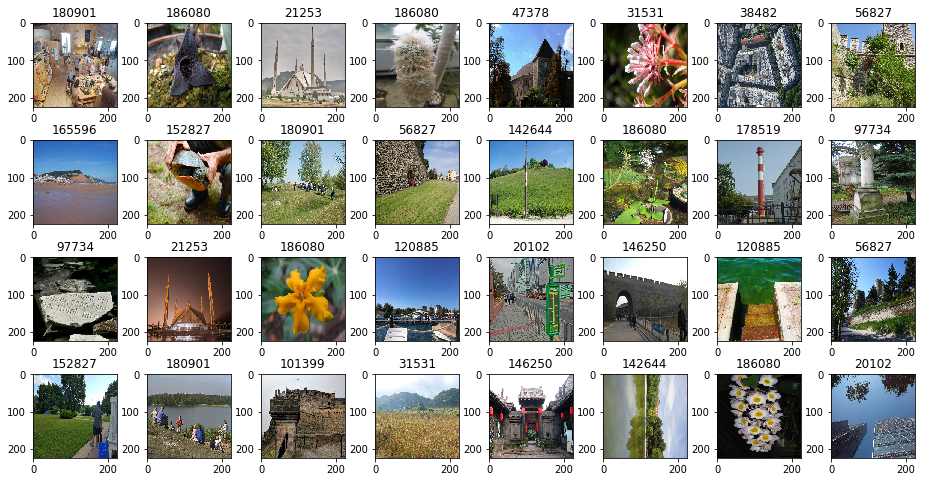

In [5]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

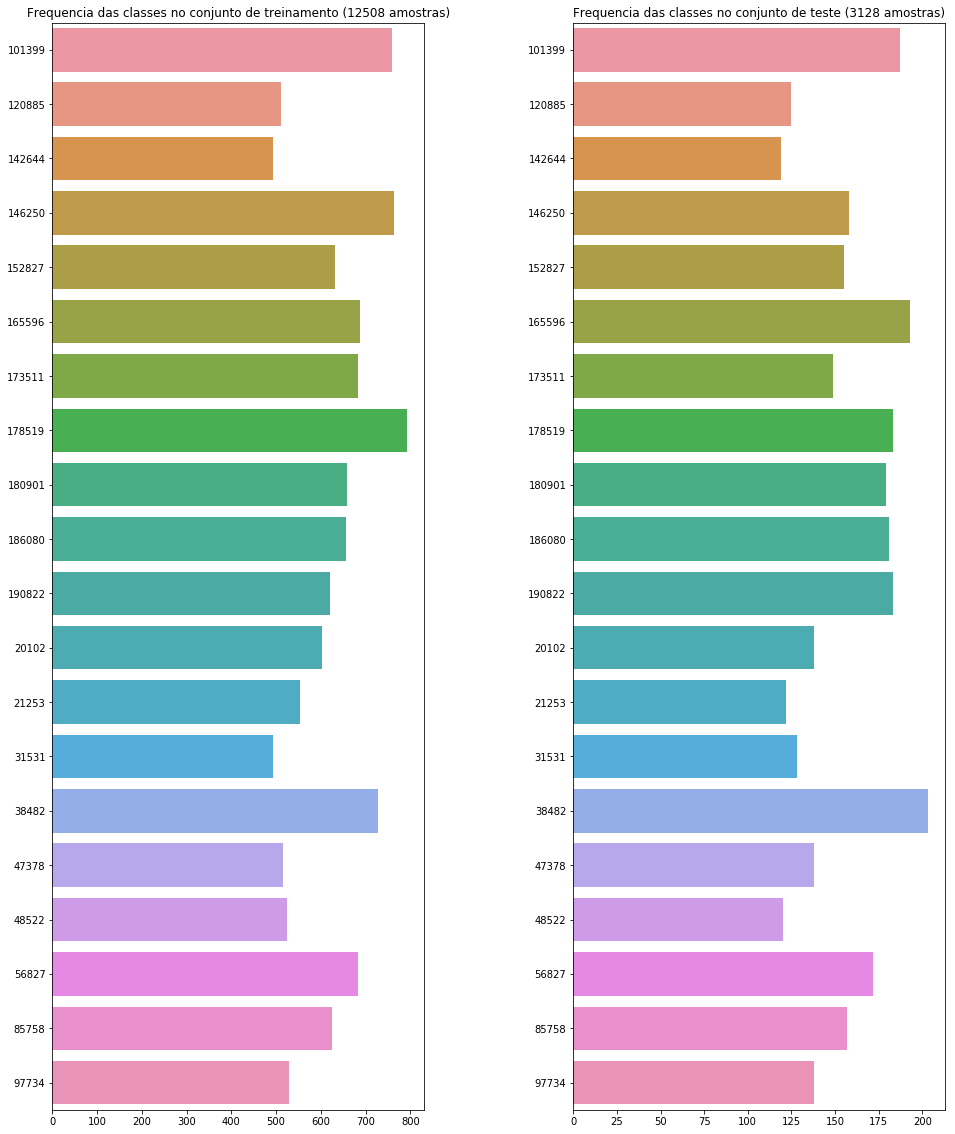

In [6]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [7]:
train_batch_size = 32 
val_batch_size = 32 
test_batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/subset_test",
                                                  target_size = target_size,
                                                  batch_size = test_batch_size,
                                                  class_mode = "categorical")

Found 10016 images belonging to 20 classes.
Found 2492 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


# Parâmetros para treinamento e validação

In [8]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 8

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

test_steps = test_generator.samples // test_batch_size

Instructions for updating:
Colocations handled automatically by placer.


# Funções de auxílio

In [9]:
df_resultado = pd.DataFrame(columns=["Rede", 
                                     "train_acc", 
                                     "train_loss", 
                                     "val_acc", 
                                     "val_loss"])
def salvar_resultado(rede,
                     train_acc,
                     train_loss,
                     val_acc,
                     val_loss,
                     df):
  
    return df.append({
            "Rede" : rede,
            "train_acc": train_acc,
            "train_loss" : train_loss,
            "val_acc": val_acc,
            "val_loss": val_loss
        },
        ignore_index = True)

In [10]:
def train_model(model, 
                name, 
                train_g = train_generator, 
                validation_g = validation_generator, 
                factor = 1,
                train_epochs = epochs):
  train_g.reset()
  validation_g.reset()
  new_epoch = train_epochs * factor
  patience = new_epoch // 3
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps / factor,
                                 epochs = new_epoch,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                                                      save_best_only=True,
                                                                      verbose=1),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [11]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [12]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [13]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [14]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [15]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [16]:
def evaluate_model(model, name, generator = validation_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/5)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/5)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/5)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/5)****')
  val_score = evaluate_generator_model(model, name + '_val', generator, steps)
  train_score = evaluate_generator_model(model, name + '_train', train_generator, train_steps)
  
  print('*** Saving results - Part (5/5)****')
  df_resultado = salvar_resultado(name, train_score[1], train_score[0], val_score[1], val_score[0], df_resultado)

In [17]:
def evaluate_test_model(model, name, generator = test_generator, steps = test_batch_size):
  print('*** Prediction model - Part (1/4)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/4)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/4)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/4)****')
  evaluate_generator_model(model, name + '_test', generator, steps)

# ResNet18 - Transfer Learning

## Fine Tuning

### Definindo a rede

In [19]:
from classification_models.resnet import ResNet18, preprocess_input
from tensorflow.python.keras.applications import ResNet50

def build_resNet50():
    model = ResNet50(input_shape = input_shape,
                     weights = "imagenet",
                     include_top=False)

    for layer in model.layers:
          layer.trainable = True

    output = model.output

    output = Flatten(name = 'flat_mdc')(output)

    output = Dense(total_classes,
                   activation ='softmax',
                   name = 'saida_mdc')(output)

    model = Model(inputs = model.input, outputs = output)

    model.compile(loss ='categorical_crossentropy', 
                  optimizer = optimizer, 
                  metrics=['accuracy'])

    return model

resNet50_tunning_model = build_resNet50()
resNet50_tunning_model.save('./model.resNet50.h5')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


AttributeError: 'Node' object has no attribute 'output_masks'

### Treinando o modelo

In [ ]:
history_resNet50_tuning = train_model(resNet50_tunning_model, name =  'ResNet50-Tuning')

In [ ]:
learning_curve_model(history_resNet50_tuning)